In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import copy
import numpy as np
from IPython.display import display
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

from pprint import pprint
from k12libs.utils.nb_easy import k12ai_get_top_dir
from k12libs.utils.nb_easy import k12ai_print
from k12libs.utils.nb_easy import K12AI_PRETRAINED_ROOT

In [3]:
pics_dir = os.path.join(k12ai_get_top_dir(), 'cv/assets/cnn')

In [4]:
!ls {pics_dir}

cat_dog.png  dd_tree.jpg  snake.jpg  spider.png


In [5]:
img_name = 'snake'
img_path = os.path.join(pics_dir, f'{img_name}.jpg')
target_class = 56

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

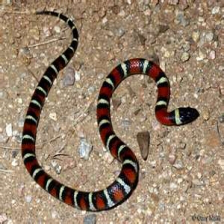

(224, 224, 'RGB')

In [6]:
original_image = Image.open(img_path).convert('RGB')
display(original_image)
original_image.width, original_image.height, original_image.mode

In [7]:
# image_raw = original_image.resize((224, 224), Image.ANTIALIAS)
# image_raw = np.array(image_raw).astype(np.uint8)
# image_raw.shape, image_raw[:, :, 0]

In [8]:
transform = transforms.Compose([
    transforms.RandomCrop(224, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
# image_tensor = transforms.ToTensor()(image_raw)
# image_tensor = transforms.Normalize(mean, std)(image_tensor)

image_tensor = transform(original_image)
image_tensor.shape, image_tensor[0, :, :]

(torch.Size([3, 224, 224]),
 tensor([[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 1.7523,  1.7865,  1.4440,  ...,  0.7933,  0.6563,  0.5707],
         [ 1.9920,  2.0948,  2.0948,  ...,  0.9132,  0.7077,  0.8104],
         [ 2.0434,  1.8037,  2.0263,  ...,  1.3242,  1.2043,  1.3413]]))

In [9]:
image_input = image_tensor.unsqueeze(0)
image_input.shape, image_input[0, 0, :, :]

(torch.Size([1, 3, 224, 224]),
 tensor([[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 1.7523,  1.7865,  1.4440,  ...,  0.7933,  0.6563,  0.5707],
         [ 1.9920,  2.0948,  2.0948,  ...,  0.9132,  0.7077,  0.8104],
         [ 2.0434,  1.8037,  2.0263,  ...,  1.3242,  1.2043,  1.3413]]))

-----------------

In [10]:
model = models.alexnet()
state = torch.load(os.path.join(K12AI_PRETRAINED_ROOT, 'cv', 'alexnet-owt-4df8aa71.pth'))
model.load_state_dict(state)

<All keys matched successfully>

In [11]:
pprint(model.features._modules)

OrderedDict([('0',
              Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))),
             ('1', ReLU(inplace=True)),
             ('2',
              MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('3',
              Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))),
             ('4', ReLU(inplace=True)),
             ('5',
              MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('6',
              Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('7', ReLU(inplace=True)),
             ('8',
              Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('9', ReLU(inplace=True)),
             ('10',
              Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('11', ReLU(inplace=True)),
             ('12',
              MaxPool2d(kernel_size=3, stride

In [12]:
gradients = dict()
def hook_function(module, grad_in, grad_out):
    gradients['in'] = grad_in
    
g_input_grad = None
def input_tensor_hook(grad): # image_input.requires_grad = True 
    global g_input_grad 
    print('input tensor_hook.grad:', grad.shape) #
    print('----------')
    g_input_grad = grad
    return grad
    
first_conv2d_layer = list(model.features._modules.items())[0][1]
first_conv2d_layer.register_backward_hook(hook_function)

print(first_conv2d_layer)

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


In [13]:
model.eval()
image_input.requires_grad = True # must true, otherwise gradients['in'][0] is None
image_input.register_hook(input_tensor_hook)
output = model(image_input)
output.size()

torch.Size([1, 1000])

In [14]:
result_onehot = torch.FloatTensor(1, output.size()[-1]).zero_()
result_onehot[0][target_class] = 1

In [15]:
model.zero_grad()
output.backward(gradient=result_onehot)

input tensor_hook.grad: torch.Size([1, 3, 224, 224])
----------


In [16]:
gradients['in'][0].shape, g_input_grad.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [17]:
gradient = g_input_grad[0]
gradient.shape, gradient.min(), gradient.max()

(torch.Size([3, 224, 224]), tensor(-0.0537), tensor(0.0791))

In [19]:
gradient -= gradient.min()
gradient /= gradient.max()
gradient.shape, gradient.min(), gradient.max()

(torch.Size([3, 224, 224]), tensor(0.), tensor(1.))

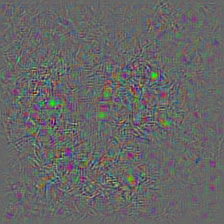

In [18]:
image_gradient = transforms.ToPILImage()(gradient)
image_gradient 

In [22]:
image_raw = np.array(image_gradient).astype(np.uint8)
image_raw.shape, image_raw.min(), image_raw.max() 

((224, 224, 3), 0, 255)